**인공지능 실습 3_1 - ResNet-18 구현(ResNet-18 with Keras Layers)**

In [14]:
import tensorflow as tf

In [15]:
class ResBlock(tf.keras.Model):
  def __init__(self, filters, downsample=False):
    super(ResBlock, self).__init__(name='')
                                                                    # 정칙화 2) Weight Decay
    self.conv1 = tf.keras.layers.Conv2D(filters, 3, padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.0005)) # padding='same' : input과 output의 사이즈가 같도록 padding을 알아서 넣어줌
    self.bn1 = tf.keras.layers.BatchNormalization() # 정칙화 3) Batch Normalization
    self.act1 = tf.keras.layers.Activation('relu')

    self.conv2 = tf.keras.layers.Conv2D(filters, 3, padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.0005))
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.act2 = tf.keras.layers.Activation('relu')

    self.add = tf.keras.layers.Add()
 
    # downsample 되는 경우 고려
    self.downsample = downsample
    if self.downsample:
      self.ds = tf.keras.layers.Conv2D(filters, strides=2, kernel_size=(1, 1), padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.0005))
      self.dsbn = tf.keras.layers.BatchNormalization()
  # override
  def call(self, inputs): 
    ds = inputs
    if self.downsample:
      ds = self.ds(inputs)
      ds = self.dsbn(ds)
    
    x = self.conv1(ds)
    x = self.bn1(x)
    x = self.act1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    
    x = self.add([x, ds])
    out = self.act2(x)

    return out

In [16]:
class ResNet18(tf.keras.Model):
  def __init__(self, num_classes):
    super(ResNet18, self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(64, strides=2, kernel_size=(7, 7), padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.0005))
    self.bn1 = tf.keras.layers.BatchNormalization()

    self.act1 = tf.keras.layers.Activation('relu')
    self.maxp = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)

    self.conv2_1 = ResBlock(64, downsample=False)
    self.conv2_2 = ResBlock(64, downsample=False)

    self.conv3_1 = ResBlock(128, downsample=True)
    self.conv3_2 = ResBlock(128, downsample=False)

    self.conv4_1 = ResBlock(256, downsample=True)
    self.conv4_2 = ResBlock(256, downsample=False)

    self.conv5_1 = ResBlock(512, downsample=True)
    self.conv5_2 = ResBlock(512, downsample=False)

    self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.flat = tf.keras.layers.Flatten()
    self.dropout = tf.keras.layers.Dropout(0.3) # 정칙화 4) Dropout
    self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.act1(x)
    x = self.maxp(x)

    for resblock in [self.conv2_1, self.conv2_2, self.conv3_1, self.conv3_2, \
                     self.conv4_1, self.conv4_2, self.conv5_1, self.conv5_2]:
      x = resblock(x)

    x = self.avg_pool(x)
    x = self.flat(x)
    x = self.dropout(x)
    out = self.fc(x)

    return out

      
    

In [17]:
model = ResNet18(10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# dataset 준비
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

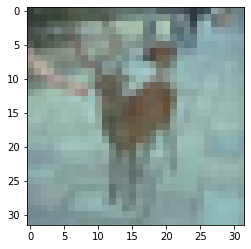

In [19]:
import matplotlib.pyplot as plt
plt.imshow(X_train[153])

In [20]:
# preprocessing
X_train = X_train.astype('float32') # 형변환
X_test = X_test.astype('float32')

X_train = X_train / 255.0
X_test = X_test / 255.0

In [21]:
# validation set 준비
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True)

In [22]:
# one-hot vector 만들기
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(Y_train)

Y_train = encoder.transform(Y_train).toarray()
Y_val = encoder.transform(Y_val).toarray()
Y_test = encoder.transform(Y_test).toarray()

In [23]:
# 정칙화 1) Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05, height_shift_range=0.05)
aug.fit(X_train)

In [24]:
# training
model.fit(aug.flow(X_train, Y_train, batch_size = 256), batch_size=256, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
157/157 [==============================] - 23s 127ms/step - loss: 3.1790 - accuracy: 0.3988 - val_loss: 4.0922 - val_accuracy: 0.1440
Epoch 2/10
157/157 [==============================] - 19s 122ms/step - loss: 2.5015 - accuracy: 0.5265 - val_loss: 3.8139 - val_accuracy: 0.1888
Epoch 3/10
157/157 [==============================] - 19s 124ms/step - loss: 2.1720 - accuracy: 0.5861 - val_loss: 3.0396 - val_accuracy: 0.3422
Epoch 4/10
157/157 [==============================] - 20s 126ms/step - loss: 1.9078 - accuracy: 0.6265 - val_loss: 2.4207 - val_accuracy: 0.4650
Epoch 5/10
157/157 [==============================] - 19s 123ms/step - loss: 1.7529 - accuracy: 0.6429 - val_loss: 1.7139 - val_accuracy: 0.6329
Epoch 6/10
157/157 [==============================] - 19s 123ms/step - loss: 1.5507 - accuracy: 0.6794 - val_loss: 1.7956 - val_accuracy: 0.5940
Epoch 7/10
157/157 [==============================] - 19s 123ms/step - loss: 1.4166 - accuracy: 0.6970 - val_loss: 1.5297 - val_ac

In [25]:
model.evaluate(X_test, Y_test) # accuracy를 높이기 위해서는 regularization 필요! ex. batch normalization

313/313 [==============================] - 3s 9ms/step - loss: 1.4491 - accuracy: 0.6386


[1.4491324424743652, 0.6385999917984009]

In [26]:
model.summary()

Model: "res_net18_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_20 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  multiple                  0         
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
  (ResBlock)                 multiple                  74368     
                                                                 
  (ResBlock)                 multiple                  